In [1]:
import lightgbm as lgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score, confusion_matrix

def eval_all(preds, dtrain):
    y_true = dtrain.get_label()
    prec, recall, thresholds = precision_recall_curve(y_true, preds)
    f1s = 2 * (prec * recall) / (prec + recall + 1e-10)
    f1s[np.isnan(f1s)] = 0
    best_idx = np.argmax(f1s)
    return [
            ('f1', f1s[best_idx], True),
            ('precision', prec[best_idx], True),
            ('recall', recall[best_idx], True),
            ]

In [ ]:
import lightgbm as lgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score, confusion_matrix

def eval_all(preds, dtrain):
    y_true = dtrain.get_label()
    prec, recall, thresholds = precision_recall_curve(y_true, preds)
    f1s = 2 * (prec * recall) / (prec + recall + 1e-10)
    f1s[np.isnan(f1s)] = 0
    best_idx = np.argmax(f1s)
    return [
            ('f1', f1s[best_idx], True),
            ('precision', prec[best_idx], True),
            ('recall', recall[best_idx], True),
            ]

In [2]:
train_df = pd.read_parquet("../Data/training_feature_v1.parquet")
test_df = pd.read_parquet("../testing/X_all.parquet")
# sudo0_df = pd.read_csv("../smt/prc9/sudo_0.csv") #180
# sudo1_df = pd.read_csv("../smt/prc9/prc9_smt_127.csv")

# sudo1_df = pd.read_csv("../testing/true127.csv")
sudo1_df= pd.read_csv('../testing/guess136.csv')

tmpl = pd.read_csv('../testing/submission_template_public_and_private.csv')

In [3]:
NUM = 1000
CUM = 15
# ========== 讀取特徵重要性 ==========
# gain = pd.read_csv(filepath_or_buffer=f'./pos_shap_abs_mean.csv', index_col=0)

# method 1
gain = pd.read_csv(filepath_or_buffer=f'./gain.csv', index_col=0)
num_trails = gain.shape[1]

res = {}
for i in range(num_trails):
    rank = gain.iloc[:, i].nlargest(n=NUM).index
    for item in rank:
        if item not in res:
            res[item] = 0
        res[item] += 1
        
rank_cnt = pd.DataFrame(res.items(), columns=['feature', 'rank'])
selected_features = rank_cnt.query(f'rank >= {CUM}')['feature']
print(f"Selected {len(selected_features)} features")
del gain

Selected 153 features


In [4]:
zero_list = [13181, 8806, 6833, 780, 20029, 
             7555, 22570, 6898, 14120, 11999, 
             8831, 6722, 8484, 12519, 14467,
             23668, 4160]

imp_zero = np.array(zero_list) - 1
imp_one = np.where(sudo1_df['飆股']==1)[0]
concat_test_idx = np.concatenate([imp_zero, imp_one])
print(f"Length of test index: {len(concat_test_idx)}")

Length of test index: 153


In [5]:
X_train_all = train_df[selected_features].values
X_test = test_df[selected_features].values

train_proportion = 0.8
y_train_all = train_df['飆股'].values
df_pos_idx = np.where(y_train_all == 1)[0]
df_neg_idx = np.where(y_train_all == 0)[0]
np.random.seed(1111)
np.random.shuffle(df_neg_idx)
np.random.shuffle(df_pos_idx)

num_train_pos = int(train_proportion * len(df_pos_idx))
num_train_neg = int(train_proportion * len(df_neg_idx))
train_idx = np.concatenate([df_pos_idx[ :num_train_pos],
                            df_neg_idx[ :num_train_neg]])

valid_idx = np.concatenate([df_pos_idx[num_train_pos: ],
                            df_neg_idx[num_train_neg: ]])

X_train = X_train_all[train_idx]
y_train = y_train_all[train_idx]
X_valid = X_train_all[valid_idx]
y_valid = y_train_all[valid_idx]

print(f"Training set proportion:\n{pd.Series(y_train).value_counts(normalize=True)}\n")
print(f"Validation set proportion:\n{pd.Series(y_valid).value_counts(normalize=True)}\n")

X_test_known = X_test[concat_test_idx]
y_test_known = np.concatenate([np.ones(len(imp_one)), np.zeros(len(imp_zero))])


X_val_aug = np.concatenate([X_valid, X_test_known], axis=0)
y_val_aug = np.concatenate([y_valid, y_test_known], axis=0)
print(f"Augmented validation set proportion:\n {pd.Series(y_val_aug).value_counts(normalize=True)} ")

Training set proportion:
0    0.992682
1    0.007318
Name: proportion, dtype: float64

Validation set proportion:
0    0.992682
1    0.007318
Name: proportion, dtype: float64

Augmented validation set proportion:
 0.0    0.989337
1.0    0.010663
Name: proportion, dtype: float64 


In [6]:
# scaler = PowerTransformer(method='yeo-johnson', standardize=True)
scaler = StandardScaler()
X_train_pt = scaler.fit_transform(X_train) 
X_valid_pt = scaler.transform(X_valid)
X_test_known_pt = scaler.transform(X_test_known)
X_val_aug_pt = scaler.transform(X_val_aug)
X_test_pt = scaler.transform(X_test)

In [7]:
lgb_train_set = lgb.Dataset(X_train_pt, y_train)
lgb_valid_aug_set = lgb.Dataset(X_val_aug_pt, y_val_aug, reference=lgb_train_set)

In [8]:
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    # 'data_sample_strategy': 'goss',
    # 'metric': ['recall', 'f1', 'precision', ],
    'metric': 'binary_logloss',
    'is_unbalance': True,
    'verbosity': -1,

    'learning_rate': 0.03,
    'num_leaves': 128,
    'max_depth': -1,
    # 'min_data_in_leaf': 500,

    'feature_fraction': 0.7,
    'bagging_fraction': 0.75,
    # 'top_rate': 0.25,
    # 'other_rate': 0.5,

    'n_jobs': 30,
}

def dynamic_lr(iteration):
    if iteration < 5000:
        return 0.03
    elif iteration < 7000:
        return 0.015
    else:
        return 0.015

model = lgb.train(
    params,
    train_set=lgb_train_set,
    valid_sets=[lgb_valid_aug_set],
    valid_names=['valid'],
    num_boost_round=7000,
    feval=[eval_all,],
    callbacks=[
        # lgb.early_stopping(stopping_rounds=3000, first_metric_only=True, verbose=True),
        lgb.log_evaluation(period=1000),
        # lgb.reset_parameter(learning_rate=dynamic_lr),
        ],
)

best_iter = model.current_iteration()
print(f"Best iteration: {best_iter}")
print(model.params)

 14%|████▏                        | 1007/7000 [00:26<01:38, 60.82it/s]

[1000]	valid's binary_logloss: 0.0329984	valid's f1: 0.816568	valid's precision: 0.831325	valid's recall: 0.802326


 29%|████████▎                    | 2010/7000 [00:39<00:59, 84.04it/s]

[2000]	valid's binary_logloss: 0.0357342	valid's f1: 0.820571	valid's precision: 0.806742	valid's recall: 0.834884


 43%|████████████▍                | 3015/7000 [00:50<00:45, 88.25it/s]

[3000]	valid's binary_logloss: 0.0365687	valid's f1: 0.822521	valid's precision: 0.868217	valid's recall: 0.781395


 57%|████████████████▋            | 4018/7000 [01:01<00:32, 92.99it/s]

[4000]	valid's binary_logloss: 0.0370503	valid's f1: 0.826406	valid's precision: 0.871134	valid's recall: 0.786047


 72%|████████████████████▊        | 5017/7000 [01:12<00:20, 94.71it/s]

[5000]	valid's binary_logloss: 0.0373505	valid's f1: 0.827586	valid's precision: 0.879581	valid's recall: 0.781395


 86%|████████████████████████▉    | 6010/7000 [01:22<00:10, 98.38it/s]

[6000]	valid's binary_logloss: 0.0376073	valid's f1: 0.827417	valid's precision: 0.873385	valid's recall: 0.786047


[7000]	valid's binary_logloss: 0.0378151	valid's f1: 0.827417	valid's precision: 0.873385	valid's recall: 0.786047
Best iteration: 7000
{'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'binary_logloss', 'is_unbalance': True, 'verbosity': -1, 'learning_rate': 0.03, 'num_leaves': 128, 'max_depth': -1, 'feature_fraction': 0.7, 'bagging_fraction': 0.75, 'n_jobs': 30, 'num_iterations': 7000}


In [9]:
val_prob = model.predict(data=X_valid_pt)

prec, recall, thresholds = precision_recall_curve(y_valid, val_prob)
prec_lst = prec[:-1]
rec_lst = recall[:-1]
f1s = 2 * prec_lst * rec_lst / (prec_lst + rec_lst + 1e-10)
best_idx = np.argmax(f1s)
best_threshold_be = thresholds[best_idx]
print(f"Best threshold: {best_threshold_be:.4f}, F1: {f1s[best_idx]:.4f}, Precision: {prec[best_idx]:.4f}, Recall: {recall[best_idx]:.4f}")
val_num_pos = np.unique((val_prob >= best_threshold_be).astype(int), return_counts=True)[1][1]
print(f"Validation num pos: {val_num_pos}\n")

known_test_prob = model.predict(data=X_test_known_pt)
known_test_pred = (known_test_prob >= best_threshold_be).astype(int)

cm = confusion_matrix(y_test_known, known_test_pred)
print(f"False positive: {cm[0][1]}, False negative: {cm[1][0]}, Wrong: {cm[0][1] + cm[1][0]}")

Best threshold: 0.0038, F1: 0.7963, Precision: 0.8740, Recall: 0.7313
Validation num pos: 246

False positive: 16, False negative: 18, Wrong: 34


In [10]:
# test_df = np.clip(test_df, -10, 10)
test_prob = model.predict(data=X_test_pt)
y_pred_label = (test_prob >= best_threshold_be).astype(int)
public_test_num_pos = np.unique(y_pred_label[:25108], return_counts=True)[1][1]
private_test_num_pos = np.unique(y_pred_label[25108:], return_counts=True)[1][1]
print(f"Before retain,  Public test num pos: {public_test_num_pos}, Private test num pos: {private_test_num_pos}")

Before retain,  Public test num pos: 144, Private test num pos: 139


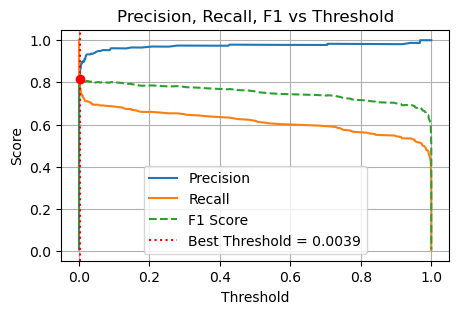

In [12]:
plt.figure(figsize=(5,3))
plt.plot(thresholds, prec_lst, label='Precision')
plt.plot(thresholds, rec_lst, label='Recall')
plt.plot(thresholds, f1s, label='F1 Score', linestyle='--')
plt.axvline(best_threshold_be, color='red', linestyle=':', label=f'Best Threshold = {best_threshold_be:.4f}')
plt.scatter(best_threshold_be, f1s[best_idx], color='red', zorder=5)

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, F1 vs Threshold')
plt.legend()
plt.grid(True)
# plt.show()  # 若有 GUI 可開啟


In [26]:
test_prob_df_be = pd.DataFrame({
    'ID': tmpl['ID'],
    'prob': test_prob,
    'pred': y_pred_label
})
pub_pred_be = sudo1_df.merge(test_prob_df_be, on='ID', how='left')
pub_pred_be.sort_values(by=['飆股', 'prob'], ascending=False).reset_index(drop=True)

,ID,飆股,prob,pred
0,PU-10413,1,1.000000e+00,1
1,PU-6548,1,1.000000e+00,1
2,PU-14894,1,1.000000e+00,1
3,PU-6741,1,1.000000e+00,1
4,PU-10860,1,1.000000e+00,1
...,...,...,...,...
25103,PU-15391,0,2.507497e-19,0
25104,PU-18984,0,1.702559e-19,0
25105,PU-13132,0,1.498584e-19,0
25106,PU-8029,0,1.080557e-19,0


In [29]:
retrain_set = np.concat([X_train, X_valid], axis=0)
retrain_label = np.concat([y_train, y_valid], axis=0)
retrain_set = lgb.Dataset(retrain_set, label=retrain_label)


final_model = lgb.train(
    params,
    train_set=retrain_set,
    num_boost_round=best_iter,
)

# train_all = lgb.Dataset(X_train_all, label=y_train_all)
# final_model = lgb.train(
#     params,
#     train_set=train_all,
#     num_boost_round=10000,
# )

In [ ]:
test_prob_af = pd.DataFrame({
    'ID': tmpl['ID'],
    'prob': retain_test_prob,
    'pred': re_y_pred_label
})
pub_pred = sudo1_df.merge(test_prob_af, on='ID', how='left')
pub_pred.sort_values(by=['prob', 'pred'], ascending=False).reset_index(drop=True)

,ID,飆股,prob,pred
0,PU-32,1,9.997485e-01,1
1,PU-123,1,9.997384e-01,1
2,PU-167,1,9.998116e-01,1
3,PU-485,1,4.504654e-01,1
4,PU-609,1,9.735317e-01,1
...,...,...,...,...
25103,PU-25104,0,1.513180e-10,0
25104,PU-25105,0,1.661277e-09,0
25105,PU-25106,0,1.882962e-12,0
25106,PU-25107,0,8.370063e-10,0


In [ ]:
pd.DataFrame({
    'ID':pub_pred['ID'],
    '飆股': (pub_pred['pred']>best_threshold_be).astype(int),
}).to_csv('./198f_9245_7656_139.csv', index=False)

In [ ]:
# pub_pos_idx = np.where(sudo1_df['飆股']==1)[0]
# concat_idx = pub_pos_idx

# pub_neg_idx = np.where(sudo1_df['飆股']==0)[0]
# num_pub_neg = int(len(pub_pos_idx)*rate)
# np.random.seed(85)
# pub_neg_idx = np.random.choice(pub_neg_idx, size=num_pub_neg, replace=False)
# concat_idx = np.concatenate([pub_pos_idx, pub_neg_idx])

In [3]:
def f1(prec, recall):
    if prec == 0 and recall == 0:
        return 0
    else:
        return (2 * prec * recall) / (prec + recall)
f1(0.942, 0.7386)

0.8279914316315601

In [ ]:
# # original training data
# train_proportion = 0.8
# df_pos_idx = np.where(train_df['飆股'] == 1)[0]
# df_neg_idx = np.where(train_df['飆股'] == 0)[0]
# np.random.seed(1111)
# np.random.shuffle(df_neg_idx)
# np.random.shuffle(df_pos_idx)

# num_train_pos = int(train_proportion * len(df_pos_idx))
# num_train_neg = int(train_proportion * len(df_neg_idx))
# train_idx = np.concatenate([df_pos_idx[ :num_train_pos],
#                             df_neg_idx[ :num_train_neg]])

# valid_idx = np.concatenate([df_pos_idx[num_train_pos: ],
#                             df_neg_idx[num_train_neg: ]])

# X_train = train_df.loc[train_idx, selected_features]
# X_valid = train_df.loc[valid_idx, selected_features]
# y_train = train_df.loc[train_idx, '飆股']
# y_valid = train_df.loc[valid_idx, '飆股']
# print(f"Training set proportion: {y_train.value_counts(normalize=True)} \n")
# print(f"Validation set proportion: {y_valid.value_counts(normalize=True)} \n")


# # known testing data
# zero_idx = np.array(zero_list) - 1
# one_idx = np.where(sudo1_df['飆股'] == 1)[0]
# concat_idx = np.concatenate((zero_idx, one_idx))
 
# X_test_all = test_df.loc[:, selected_features]
# X_test_known = X_test_all.loc[concat_idx]
# y_test_known = sudo1_df.loc[concat_idx, '飆股']
# print(f"Length of known testing set: {len(X_test_known)}")
# print(f"Known testing set proportion: {y_test_known.value_counts(normalize=True)} \n")